In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

In [2]:
from tqdm import tqdm
import pandas as pd
import numpy as np

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from utils.helper import *

In [3]:
df = pd.read_csv("../../data/Final_Btc_Data_with_Indicators.csv", parse_dates=['Date'])

target_col = "Price"
features = [col for col in df.columns if col != target_col and col != "Date"]

df = scaled_data(df)

seq_len = 5
horizon = 1
X, y = create_sequences(df[features].values, df[target_col].values, seq_len, horizon)

/Users/sohamsamal/Documents/Coding/Research/research-btc-pred/venv/lib/python3.11/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
batch_size = 256

train_loader, val_loader, test_loader = data_loaders(df, X, y, batch_size=batch_size)

In [5]:
class CNNBiLSTM(nn.Module):
    def __init__(self, input_dim, num_filters=32, num_bilstm_layers=2, lstm_hidden=64, filter_size=(10, 1), input_lstm_dim=100, dropout_rate=0.25):
        super().__init__()
        self.conv1 = nn.Conv1d(
            in_channels=input_dim,
            out_channels=num_filters,
            kernel_size=filter_size[0],
            stride=1,
            padding=filter_size[0] // 2
        )

        self.proj = nn.Linear(num_filters, input_lstm_dim)

        self.relu = nn.ReLU()

        self.bilstm1 = nn.LSTM(
            input_size=input_lstm_dim,
            hidden_size=lstm_hidden,
            batch_first=True,
            bidirectional=True
        )

        self.drop1 = nn.Dropout(dropout_rate)

        self.bilstm2 = nn.LSTM(
            input_size = 2 * lstm_hidden,
            hidden_size=lstm_hidden,
            batch_first=True,
            bidirectional=True
        )

        self.fc = nn.Linear(lstm_hidden * 2, 1)


    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))

        x = x.permute(0, 2, 1)
        x = self.relu(self.proj(x))

        # BiLSTM layers
        out, _ = self.bilstm1(x)
        out = self.drop1(out)
        out, _ = self.bilstm2(out)

        # take last time step
        out = out[:, -1, :]
        out = self.fc(out)
        return out.squeeze(-1)

In [6]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [7]:
model = CNNBiLSTM(input_dim=len(features))

In [8]:
decay_rate = 0.8
num_epochs = 500
learning_rate = 0.001
l2_penalty = 0.001

In [9]:
# Training the model using the train_loader, val_loader, and test_loader
model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    # weight_decay=l2_penalty
)

num_epochs = 300
best_val_loss = float('inf')
patience = 30
patience_counter = 0

# Load existing model's best validation loss if it exists
existing_model_path = '../../models/temp_models/cnn_bilstm5.pth'
existing_best_val_loss = float('inf')

if os.path.exists(existing_model_path):
    try:
        # Create a temporary model to load and evaluate the existing model
        temp_lstm = CNNBiLSTM(input_dim=len(features)).to(device)
        temp_lstm.load_state_dict(torch.load(existing_model_path))
        temp_lstm.eval()

        # Evaluate existing model on validation set
        existing_val_loss = 0.0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = temp_lstm(batch_x)
                loss = criterion(outputs, batch_y)
                existing_val_loss += loss.item()

        existing_best_val_loss = existing_val_loss / len(val_loader)
        print(f"Existing model validation loss: {existing_best_val_loss:.6f}")

        # Delete temporary model to free memory
        del temp_lstm
        torch.cuda.empty_cache() if torch.cuda.is_available() else None

    except Exception as e:
        print(f"Could not load existing model: {e}")
        existing_best_val_loss = float('inf')

train_losses = []
val_losses = []

print(f"Training on device: {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")

for epoch in range(num_epochs):

    print(f"{'='*40}")
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"{'-'*40}")

    model.train()
    train_loss = 0.0

    for batch_x, batch_y in tqdm(train_loader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for batch_x, batch_y in tqdm(val_loader):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # Early stopping and model saving
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

    # Early stopping check
    if patience_counter >= patience:
        print(f'Early stopping triggered after epoch {epoch+1}')
        break

# After training is complete, compare with existing model and save only if better
if best_val_loss < existing_best_val_loss:
    torch.save(model.state_dict(), existing_model_path)
    print(f'\nNew model is better! Saved with validation loss: {best_val_loss:.6f}')
    print(f'Previous best was: {existing_best_val_loss:.6f}')
else:
    print(f'\nExisting model is better. Not saving new model.')
    print(f'New model validation loss: {best_val_loss:.6f}')
    print(f'Existing model validation loss: {existing_best_val_loss:.6f}')

print(f'\nBest validation loss achieved this training: {best_val_loss:.6f}')

Existing model validation loss: 1.251884
Training on device: mps
Model parameters: 192261
Epoch 1/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 173.43it/s]


Epoch [1/300] - Train Loss: 1.169216, Val Loss: 21.174987
Epoch 2/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 247.68it/s]


Epoch [2/300] - Train Loss: 0.947084, Val Loss: 18.452854
Epoch 3/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 209.14it/s]


Epoch [3/300] - Train Loss: 0.680355, Val Loss: 14.083549
Epoch 4/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 208.57it/s]


Epoch [4/300] - Train Loss: 0.422250, Val Loss: 8.499744
Epoch 5/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 231.10it/s]


Epoch [5/300] - Train Loss: 0.300329, Val Loss: 4.343863
Epoch 6/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 225.02it/s]


Epoch [6/300] - Train Loss: 0.135145, Val Loss: 2.904807
Epoch 7/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 211.46it/s]


Epoch [7/300] - Train Loss: 0.071641, Val Loss: 1.008405
Epoch 8/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 198.63it/s]


Epoch [8/300] - Train Loss: 0.044790, Val Loss: 0.483660
Epoch 9/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 211.19it/s]


Epoch [9/300] - Train Loss: 0.030484, Val Loss: 0.302498
Epoch 10/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 231.93it/s]


Epoch [10/300] - Train Loss: 0.028744, Val Loss: 0.400205
Epoch 11/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 247.80it/s]


Epoch [11/300] - Train Loss: 0.080486, Val Loss: 0.312495
Epoch 12/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 275.90it/s]


Epoch [12/300] - Train Loss: 0.125894, Val Loss: 1.155590
Epoch 13/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 250.47it/s]


Epoch [13/300] - Train Loss: 0.113515, Val Loss: 0.800079
Epoch 14/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 263.40it/s]


Epoch [14/300] - Train Loss: 0.029865, Val Loss: 0.691230
Epoch 15/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 232.29it/s]


Epoch [15/300] - Train Loss: 0.026107, Val Loss: 0.610039
Epoch 16/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 179.24it/s]


Epoch [16/300] - Train Loss: 0.021772, Val Loss: 0.381640
Epoch 17/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 254.52it/s]


Epoch [17/300] - Train Loss: 0.017374, Val Loss: 0.471660
Epoch 18/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 202.24it/s]


Epoch [18/300] - Train Loss: 0.015921, Val Loss: 0.556891
Epoch 19/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 213.36it/s]


Epoch [19/300] - Train Loss: 0.013881, Val Loss: 0.502897
Epoch 20/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 169.58it/s]


Epoch [20/300] - Train Loss: 0.011914, Val Loss: 0.627354
Epoch 21/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 275.45it/s]


Epoch [21/300] - Train Loss: 0.009795, Val Loss: 0.687648
Epoch 22/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 171.16it/s]


Epoch [22/300] - Train Loss: 0.010144, Val Loss: 0.728527
Epoch 23/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 262.78it/s]


Epoch [23/300] - Train Loss: 0.010936, Val Loss: 0.678693
Epoch 24/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 230.73it/s]


Epoch [24/300] - Train Loss: 0.012220, Val Loss: 0.796665
Epoch 25/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 251.20it/s]


Epoch [25/300] - Train Loss: 0.025507, Val Loss: 0.430522
Epoch 26/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 222.20it/s]


Epoch [26/300] - Train Loss: 0.062771, Val Loss: 1.629238
Epoch 27/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 238.96it/s]


Epoch [27/300] - Train Loss: 0.070426, Val Loss: 0.252846
Epoch 28/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 244.68it/s]


Epoch [28/300] - Train Loss: 0.037356, Val Loss: 1.360694
Epoch 29/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 247.49it/s]


Epoch [29/300] - Train Loss: 0.013170, Val Loss: 0.470871
Epoch 30/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 204.96it/s]


Epoch [30/300] - Train Loss: 0.013508, Val Loss: 0.511236
Epoch 31/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 223.44it/s]


Epoch [31/300] - Train Loss: 0.011377, Val Loss: 0.750653
Epoch 32/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 266.31it/s]


Epoch [32/300] - Train Loss: 0.010375, Val Loss: 0.596831
Epoch 33/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 240.18it/s]


Epoch [33/300] - Train Loss: 0.009168, Val Loss: 0.709868
Epoch 34/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 276.32it/s]


Epoch [34/300] - Train Loss: 0.009343, Val Loss: 0.658737
Epoch 35/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 221.97it/s]


Epoch [35/300] - Train Loss: 0.007199, Val Loss: 0.764610
Epoch 36/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 252.87it/s]


Epoch [36/300] - Train Loss: 0.007952, Val Loss: 0.722066
Epoch 37/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 271.14it/s]


Epoch [37/300] - Train Loss: 0.007252, Val Loss: 0.756339
Epoch 38/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 209.93it/s]


Epoch [38/300] - Train Loss: 0.006724, Val Loss: 0.698371
Epoch 39/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 266.80it/s]


Epoch [39/300] - Train Loss: 0.007649, Val Loss: 0.816093
Epoch 40/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 284.20it/s]


Epoch [40/300] - Train Loss: 0.009278, Val Loss: 0.563221
Epoch 41/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 225.99it/s]


Epoch [41/300] - Train Loss: 0.013660, Val Loss: 1.015217
Epoch 42/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 262.84it/s]


Epoch [42/300] - Train Loss: 0.024403, Val Loss: 0.359665
Epoch 43/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 169.84it/s]


Epoch [43/300] - Train Loss: 0.048168, Val Loss: 1.528988
Epoch 44/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 258.87it/s]


Epoch [44/300] - Train Loss: 0.072085, Val Loss: 0.215755
Epoch 45/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 279.56it/s]


Epoch [45/300] - Train Loss: 0.054115, Val Loss: 1.682362
Epoch 46/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 241.34it/s]


Epoch [46/300] - Train Loss: 0.022832, Val Loss: 0.325877
Epoch 47/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 264.90it/s]


Epoch [47/300] - Train Loss: 0.010009, Val Loss: 0.735169
Epoch 48/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 277.78it/s]


Epoch [48/300] - Train Loss: 0.009547, Val Loss: 0.748117
Epoch 49/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 277.63it/s]


Epoch [49/300] - Train Loss: 0.009077, Val Loss: 0.600710
Epoch 50/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 300.93it/s]


Epoch [50/300] - Train Loss: 0.007441, Val Loss: 0.792601
Epoch 51/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 233.29it/s]


Epoch [51/300] - Train Loss: 0.006445, Val Loss: 0.690297
Epoch 52/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 273.94it/s]


Epoch [52/300] - Train Loss: 0.006500, Val Loss: 0.775921
Epoch 53/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 262.09it/s]


Epoch [53/300] - Train Loss: 0.006588, Val Loss: 0.783300
Epoch 54/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 220.77it/s]


Epoch [54/300] - Train Loss: 0.006796, Val Loss: 0.866385
Epoch 55/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 218.70it/s]


Epoch [55/300] - Train Loss: 0.008539, Val Loss: 0.669972
Epoch 56/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 218.96it/s]


Epoch [56/300] - Train Loss: 0.016975, Val Loss: 1.207961
Epoch 57/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 194.46it/s]


Epoch [57/300] - Train Loss: 0.024005, Val Loss: 0.335895
Epoch 58/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 225.89it/s]


Epoch [58/300] - Train Loss: 0.026860, Val Loss: 1.385855
Epoch 59/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 257.53it/s]


Epoch [59/300] - Train Loss: 0.023592, Val Loss: 0.299696
Epoch 60/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 183.18it/s]


Epoch [60/300] - Train Loss: 0.014907, Val Loss: 1.139290
Epoch 61/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 271.20it/s]


Epoch [61/300] - Train Loss: 0.009288, Val Loss: 0.502359
Epoch 62/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 244.07it/s]


Epoch [62/300] - Train Loss: 0.006817, Val Loss: 0.819319
Epoch 63/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 173.45it/s]


Epoch [63/300] - Train Loss: 0.005877, Val Loss: 0.641573
Epoch 64/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 258.63it/s]


Epoch [64/300] - Train Loss: 0.005750, Val Loss: 0.707215
Epoch 65/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 257.49it/s]


Epoch [65/300] - Train Loss: 0.005912, Val Loss: 0.723245
Epoch 66/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 65.59it/s]


Epoch [66/300] - Train Loss: 0.005893, Val Loss: 0.744703
Epoch 67/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 268.28it/s]


Epoch [67/300] - Train Loss: 0.005635, Val Loss: 0.755685
Epoch 68/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 267.37it/s]


Epoch [68/300] - Train Loss: 0.005377, Val Loss: 0.674956
Epoch 69/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 224.54it/s]


Epoch [69/300] - Train Loss: 0.005015, Val Loss: 0.733376
Epoch 70/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 139.72it/s]


Epoch [70/300] - Train Loss: 0.005182, Val Loss: 0.647882
Epoch 71/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 219.47it/s]


Epoch [71/300] - Train Loss: 0.005077, Val Loss: 0.799080
Epoch 72/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 220.19it/s]


Epoch [72/300] - Train Loss: 0.005611, Val Loss: 0.569572
Epoch 73/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 194.97it/s]


Epoch [73/300] - Train Loss: 0.007231, Val Loss: 0.881844
Epoch 74/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 222.13it/s]

Epoch [74/300] - Train Loss: 0.011854, Val Loss: 0.464445
Early stopping triggered after epoch 74

New model is better! Saved with validation loss: 0.215755
Previous best was: 1.251884

Best validation loss achieved this training: 0.215755


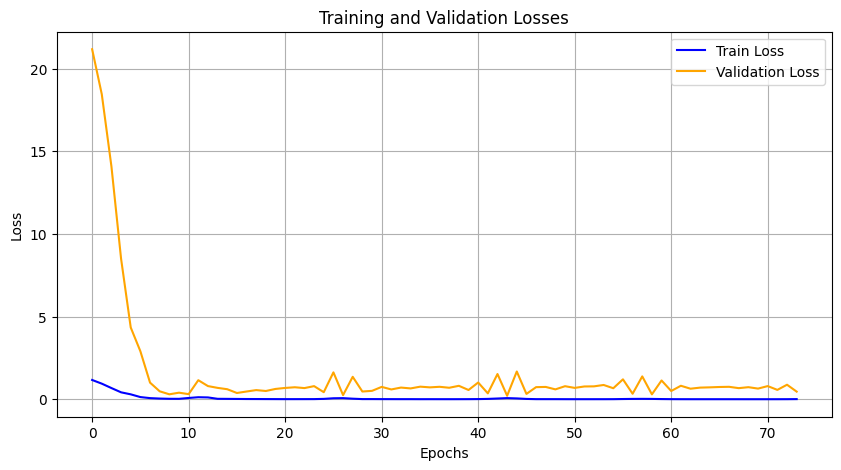

In [10]:
import matplotlib.pyplot as plt

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid()
plt.show()

In [11]:
# Test phase
model.eval()
test_loss = 0.0
test_predictions = []
test_targets = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()

        test_predictions.extend(outputs.cpu().numpy())
        test_targets.extend(batch_y.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
print(f'Test Loss: {avg_test_loss:.6f}')

# Convert to numpy arrays for analysis
test_predictions = np.array(test_predictions)
test_targets = np.array(test_targets)

Test Loss: 0.166103


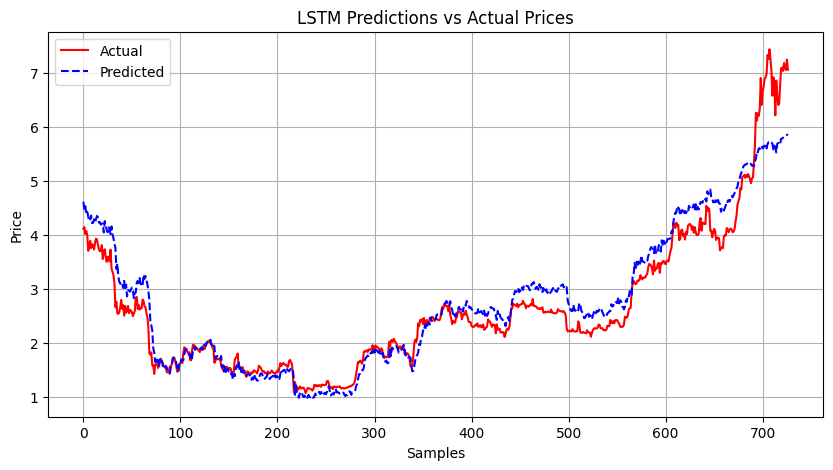

In [12]:
# plot predictions vs targets
plt.figure(figsize=(10, 5))
plt.plot(test_targets, label='Actual', color='red')
plt.plot(test_predictions, label='Predicted', color='blue', linestyle='--')
plt.xlabel('Samples')
plt.ylabel('Price')
plt.title('LSTM Predictions vs Actual Prices')
plt.legend()
plt.grid()
plt.show()